In [1]:
import numpy as np
import math
import pandas as pd
import cv2
import os
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.stats import norm
from IPython.display import Image
from io import BytesIO
%matplotlib inline

In [2]:
# data_path = "/home/nick/data/poc3/2019-10-16T10:10:49.341Z"
data_path = "/home/nick/data/poc3/2019-10-25T10:36:11.736Z"
column_names = ["timestamp", "speed", "throttle", "steering", "engine_rpm", "gear", "left_oid", "center_oid", "right_oid"]
data_df = pd.read_csv(data_path+'/vehicle_state.csv', names=column_names, parse_dates=["timestamp"], date_parser=pd.to_datetime)
data_df.dtypes

timestamp     datetime64[ns, UTC]
speed                     float64
throttle                  float64
steering                  float64
engine_rpm                float64
gear                        int64
left_oid                   object
center_oid                 object
right_oid                  object
dtype: object

In [3]:
data_df.iloc[:5]

,timestamp,speed,throttle,steering,engine_rpm,gear,left_oid,center_oid,right_oid
0,2019-10-25 10:36:14.695000+00:00,0.0,0.0,0.0,0.0,0,CA83E695FB471A5ED7DD03B93092E5DF,994399845E4AD7AE7BA2FEA727561CB8,2EAE8BC6F2483FA63F4D7F90199EECEF
1,2019-10-25 10:36:14.838000+00:00,0.0,0.0,0.0,0.0,0,00AB8C9D7B4164A67FD787BDFAE86A8E,4E1014D91A438EC3C4BD5A8701095022,FD329BA3FE40580A64B55B91E676FD4F
2,2019-10-25 10:36:14.993000+00:00,0.0,0.0,0.0,0.0,0,0B01B144A4417D44E2DF9E9ED0A82300,1152A92CFF4792E3A10E10930DC2A992,6D27F79F964E1C04FC970598C8C25F50
3,2019-10-25 10:36:15.131000+00:00,0.0,0.0,0.0,0.0,0,7BB9197C484D06B8B35DFB930E622833,8DD05D35904B0C2FC3CD73B3FA113C83,7B61233EAE492151BC8B7BA1DD2EE31C
4,2019-10-25 10:36:15.270000+00:00,0.0,0.0,0.0,0.0,0,25FB1EAD11497AB26EF704B0C5DFDD89,D4D3E129D34FDBB39465C6A5F3E9BD98,A169AE9C5A43CE27AB5B34B2138275FF


In [4]:
len(data_df)

3107

In [5]:
data_df['timestamp'].max()-data_df['timestamp'].min()

Timedelta('0 days 00:06:41.440000')

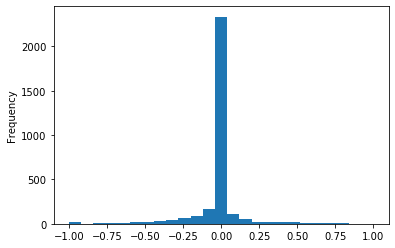

In [6]:
data_df['steering'].plot.hist(bins=25)

In [7]:
data_df['steering'].describe()

count    3107.000000
mean       -0.019493
std         0.167820
min        -1.000000
25%        -0.002514
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

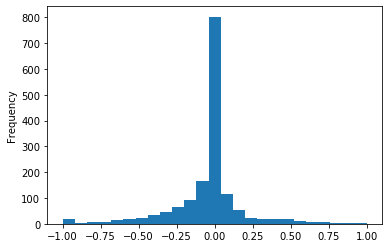

In [8]:
data_df.query('steering != 0')['steering'].plot.hist(bins=25)

In [9]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'png', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    #vmax = 255 if arr.dtype == 'uint8' else 1.0
    vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

def load_image(data_path, oid):
    filename = data_path+'/'+oid+'.jpg'
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

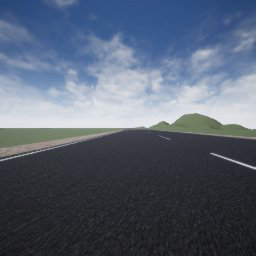

In [11]:
img=load_image(data_path,'C12215ADEF44B629A91582AA091FA71A')
arr2img(img)

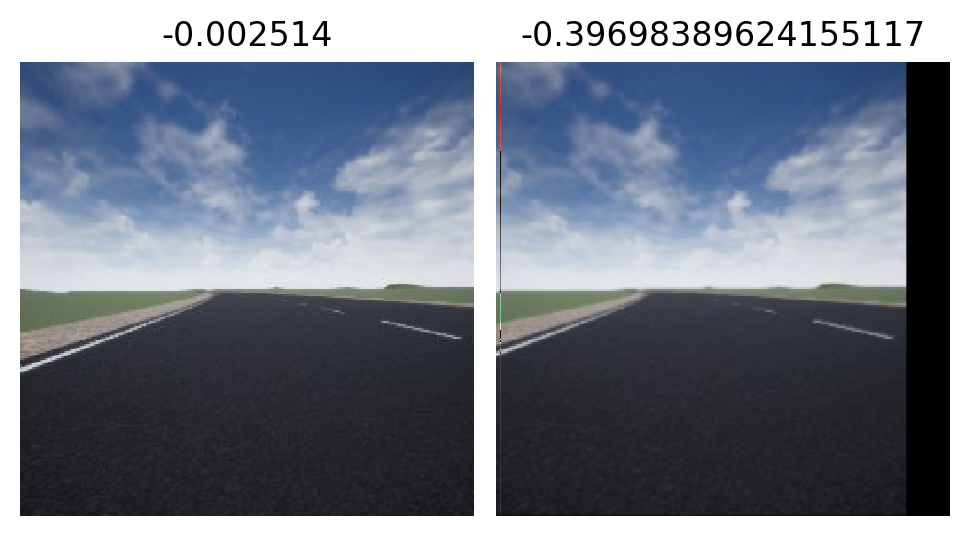

In [12]:
def randomise_image_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # brightness
    bv = .7 + np.random.random()
    hsv[::,2] = hsv[::,2]*bv

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
 
# used this routine from https://github.com/mvpcom/Udacity-CarND-Project-3
def jitter_image_rotation(image, steering):
    rows, cols, _ = image.shape
    transRange = 50
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    steering = steering + transX/transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return (image, steering)

def plot_jitter_sample(data_df, idx):
    logdata=data_df.iloc[idx]
    img1 = load_image(data_path, logdata.center_oid)
    steering1 = logdata.steering
    img2, steering2 = jitter_image_rotation(img1, steering1)
    img2 = randomise_image_brightness(img2)
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,2,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.title(steering1)
    plt.axis('off')
    plt.imshow(img1)
    fig.add_subplot(gs1[1])
    plt.title(steering2)
    plt.axis('off')
    plt.imshow(img2)
    
plot_jitter_sample(data_df,1250)

In [13]:
def draw_cameras(img_left, img_center, img_right, telemetry):
    height = img_center.shape[0]
    width = img_center.shape[1]
    steering = telemetry['steering']
    
    txt='%.3f' % (steering)
    
    pad=np.zeros((height,10,3), np.uint8)
    
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img_center,txt,(int(width/2)-75,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    return np.hstack((img_left, pad, img_center, pad, img_right))

def plot_cameras(img_left, img_center, img_right):
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,3,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.imshow(img_left)
    plt.title('left')
    plt.axis('off')
    fig.add_subplot(gs1[1])
    plt.imshow(img_center)
    plt.title('center')
    plt.axis('off')
    fig.add_subplot(gs1[2])
    plt.imshow(img_right)
    plt.title('right')
    plt.axis('off')

In [14]:
def get_telemetry(row):
    vehicle_controls = ['steering', 'throttle']
    controls = {control:getattr(row, control) for control in vehicle_controls}
    return controls

def crop_camera(img, crop_height=66, crop_width=200):
    height = img.shape[0]
    width = img.shape[1]
    
#     y_start=60+random.randint(-10,10)
#     x_start=int(width/2)-int(crop_width/2)+random.randint(-40,40)
    y_start=120
    x_start=int(width/2)-int(crop_width/2)
    
    return img[y_start:y_start+crop_height,x_start:x_start+crop_width]
    
def load_and_plot(log_index):
    logdata=data_df.iloc[log_index]
    t=get_telemetry(logdata)
    img_left=load_image(data_path, logdata.left_oid)
    img_center=load_image(data_path, logdata.center_oid)
    img_right=load_image(data_path, logdata.right_oid)
    plot_cameras(img_left, img_center, img_right)

def load_and_draw(data_df, data_path, log_index):
    logdata=data_df.iloc[log_index]
    t=get_telemetry(logdata)
    img_left=crop_camera(load_image(data_path, logdata.left_oid))
    img_center=crop_camera(load_image(data_path, logdata.center_oid))
    img_right=crop_camera(load_image(data_path, logdata.right_oid))
    return draw_cameras(img_left, img_center, img_right,t)

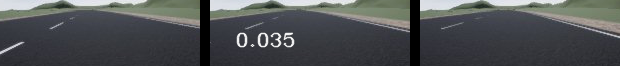

In [15]:
arr2img(load_and_draw(data_df, data_path, log_index=1000))

In [16]:
from moviepy.editor import *
from IPython.display import HTML

In [17]:
def create_movie_from_log(data_path, log_file='vehicle_state.csv', skiprows=0, clip_name='log_clip.mp4', sample_every=1):
    column_names = ["timestamp", "speed", "throttle", "steering", "engine_rpm", "gear", "left_oid", "center_oid", "right_oid"]
    data_df = pd.read_csv(data_path+'/'+log_file, names=column_names, parse_dates=["timestamp"], date_parser=pd.to_datetime)
    clip_data=[load_and_draw(data_df, data_path, idx) for idx in data_df.index if not idx % sample_every]
    clip = ImageSequenceClip(clip_data, fps=50)
    %time clip.write_videofile(clip_name, audio=False)

In [18]:
clip_name='simtrack1_sample.mp4'
create_movie_from_log(data_path, clip_name=clip_name)

[MoviePy] >>>> Building video simtrack1_sample.mp4
[MoviePy] Writing video simtrack1_sample.mp4


100%|██████████| 3108/3108 [00:06<00:00, 472.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: simtrack1_sample.mp4 

CPU times: user 2.01 s, sys: 126 ms, total: 2.14 s
Wall time: 6.68 s


In [19]:
HTML("""
<video width="960" height="150" controls>
  <source src="{0}">
</video>
""".format(clip_name))